In [1]:
import pandas as pd
import plotly.express as px

# Load the cleaned data
file_path = 'final_cleaned_Reaxys_data.xlsx'
data = pd.read_excel(file_path)

# Fill NaN values with 'None' to ensure combinations with missing values are counted
data = data.fillna('None')

# Count the frequency of each unique combination of Catalyst, Ligand, and Base
combination_counts = data.groupby(['Catalyst', 'Ligand', 'Base']).size().reset_index(name='Frequency')

# Sort combinations by frequency in descending order
combination_counts = combination_counts.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Create a hover text with details of each combination
combination_counts['Hover Text'] = (
    'Catalyst: ' + combination_counts['Catalyst'] +
    '<br>Ligand: ' + combination_counts['Ligand'] +
    '<br>Base: ' + combination_counts['Base'] +
    '<br>Frequency: ' + combination_counts['Frequency'].astype(str)
)

# Plot an interactive histogram
fig = px.bar(
    combination_counts,
    x=combination_counts.index,  # Ranked combinations by frequency
    y='Frequency',
    hover_data={'Hover Text': True, 'Frequency': False},
    labels={'x': 'Ranked Combination Index', 'Frequency': 'Frequency'},
    title='Frequency of Catalyst, Ligand, and Base Combinations (Ranked)'
)

# Customize hover text to display combination details
fig.update_traces(hovertemplate='%{customdata[0]}')

# Customize layout
fig.update_layout(
    xaxis_title='Ranked Combination Index',
    yaxis_title='Frequency',
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
)

# Show the plot
fig.show()


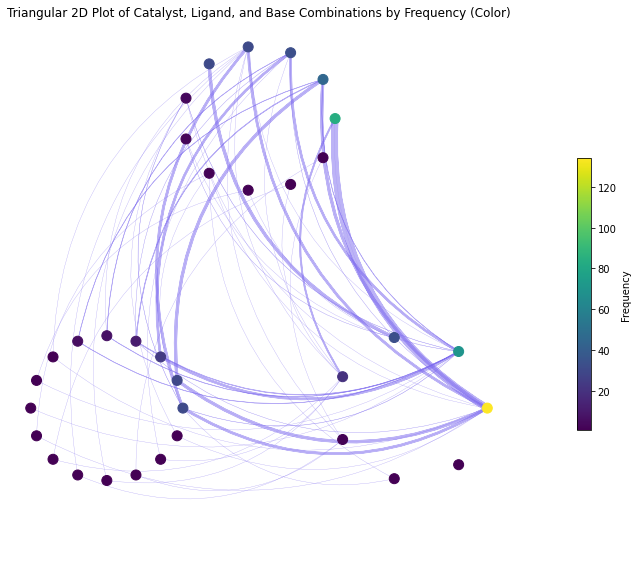

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import FancyArrowPatch

# Load the cleaned data
file_path = 'final_cleaned_Reaxys_data.xlsx'
data = pd.read_excel(file_path)

# Count the frequency of each unique reagent
catalyst_counts = data['Catalyst'].value_counts()
ligand_counts = data['Ligand'].value_counts()
base_counts = data['Base'].value_counts()

# Count the frequency of each unique combination, including missing values for one of the reagents
combination_counts = pd.concat([
    data.groupby(['Catalyst', 'Ligand'])['Base'].apply(lambda x: x.isna().sum()).reset_index(name='Frequency'),
    data.groupby(['Catalyst', 'Base'])['Ligand'].apply(lambda x: x.isna().sum()).reset_index(name='Frequency'),
    data.groupby(['Ligand', 'Base'])['Catalyst'].apply(lambda x: x.isna().sum()).reset_index(name='Frequency'),
    data.groupby(['Catalyst', 'Ligand', 'Base']).size().reset_index(name='Frequency')
], ignore_index=True)

# Initialize the graph
G = nx.Graph()

# Define center positions for each circle at the triangle vertices
triangle_positions = {
    'Catalyst': (0, 1),    # Top vertex
    'Ligand': (-1, -1),    # Bottom left vertex
    'Base': (1, -1)        # Bottom right vertex
}

# Function to generate structured circular positioning
def circular_positions(center, num_points, radius=0.5):
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    return [(center[0] + radius * np.cos(angle), center[1] + radius * np.sin(angle)) for angle in angles]

# Add nodes for each unique reagent in Catalyst, Ligand, and Base with structured positions in a circular area
for i, (catalyst, count) in enumerate(catalyst_counts.items()):
    G.add_node(catalyst, type='Catalyst', pos=circular_positions(triangle_positions['Catalyst'], len(catalyst_counts))[i], color=count)

for i, (ligand, count) in enumerate(ligand_counts.items()):
    G.add_node(ligand, type='Ligand', pos=circular_positions(triangle_positions['Ligand'], len(ligand_counts))[i], color=count)

for i, (base, count) in enumerate(base_counts.items()):
    G.add_node(base, type='Base', pos=circular_positions(triangle_positions['Base'], len(base_counts))[i], color=count)

# Add edges based on the combination data, using frequency as a weight
for _, row in combination_counts.iterrows():
    catalyst, ligand, base, frequency = row.get('Catalyst'), row.get('Ligand'), row.get('Base'), row['Frequency']

    # Connect available pairs
    if pd.notna(catalyst) and pd.notna(ligand):
        G.add_edge(catalyst, ligand, weight=frequency)
    if pd.notna(ligand) and pd.notna(base):
        G.add_edge(ligand, base, weight=frequency)
    if pd.notna(catalyst) and pd.notna(base):
        G.add_edge(catalyst, base, weight=frequency)

# Extract positions and colors for each node
pos = {node: G.nodes[node]['pos'] for node in G.nodes()}
node_colors = [G.nodes[node]['color'] for node in G.nodes()]

# Normalize color values to use with viridis colormap
norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
cmap = plt.cm.viridis
node_color_map = [cmap(norm(freq)) for freq in node_colors]

# Draw nodes with color representing frequency
fig, ax = plt.subplots(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['type'] == 'Catalyst'], 
                       node_color=[node_color_map[i] for i, n in enumerate(G.nodes) if G.nodes[n]['type'] == 'Catalyst'],
                       node_size=100, label='Catalyst', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['type'] == 'Ligand'], 
                       node_color=[node_color_map[i] for i, n in enumerate(G.nodes) if G.nodes[n]['type'] == 'Ligand'],
                       node_size=100, label='Ligand', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['type'] == 'Base'], 
                       node_color=[node_color_map[i] for i, n in enumerate(G.nodes) if G.nodes[n]['type'] == 'Base'],
                       node_size=100, label='Base', ax=ax)

# Manually draw curved edges with FancyArrowPatch
for (u, v, data) in G.edges(data=True):
    weight = data['weight'] * 0.1  # Scale weight for thickness
    color = 'mediumslateblue'
    arrow = FancyArrowPatch(posA=pos[u], posB=pos[v], connectionstyle="arc3,rad=0.3",
                            color=color, linewidth=weight, alpha=0.5)
    ax.add_patch(arrow)

# # Draw labels with offset to avoid overlap with nodes
# label_pos = {k: (v[0], v[1] + 0.1) for k, v in pos.items()}  # Adjust label position slightly above the nodes
# nx.draw_networkx_labels(G, label_pos, font_size=8, ax=ax)

ax.set_axis_off()


# Color bar to indicate frequency
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1, shrink=0.5)
cbar.set_label('Frequency')

# Title and display
plt.title("Triangular 2D Plot of Catalyst, Ligand, and Base Combinations by Frequency (Color)")
plt.show()
